<a href="https://colab.research.google.com/github/ravifrancesco/ECG_Heartbeat_Classification/blob/vanillaRNNPTB/PTBRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Checking resources

In [36]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


2) Setting up colab

In [37]:
# Gloabal variables
data_path = "/content/gdrive/My Drive/ETH/MLH/Project1/data/"
model_path = "/content/gdrive/My Drive/ETH/MLH/Project1/model/"

random_seed = 50

In [38]:
# Mount Google Drive and set data paths.
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


3) Imports

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, optimizers, losses
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

4) Loading data

In [40]:
df_1 = pd.read_csv(data_path + "input/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv(data_path + "input/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

print("X shape is {}".format(X.shape))
print("Y shape is {}".format(Y.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X shape is (11641, 187, 1)
Y shape is (11641,)
X_test shape is (2911, 187, 1)
Y_test shape is (2911,)


5) Visualizing data

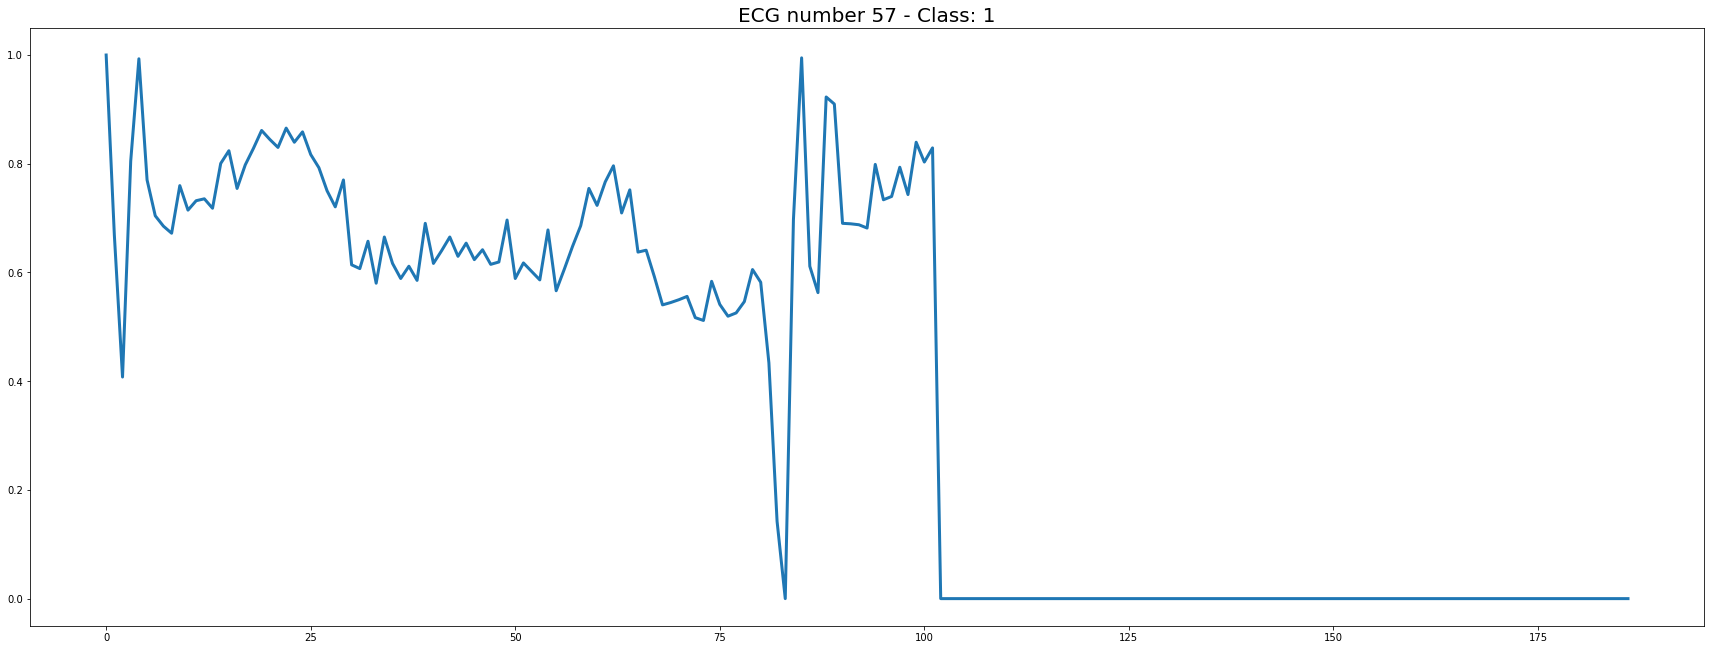

In [41]:
# Plotting one signal
example_signal = 56
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
plt.plot(X[example_signal])
plt.title("ECG number {} - Class: {}".format(example_signal+1, Y[example_signal]), size = 20)
plt.show()

6) Creating validation set

In [42]:
# Splitting dataset for validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=random_seed)
for train_index, test_index in sss.split(X, Y):
    X_train, X_val = X[train_index], X[test_index]
    Y_train, Y_val = Y[train_index], Y[test_index]

print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_val shape is {}".format(X_val.shape))
print("Y_val shape is {}".format(Y_val.shape))

X_train shape is (10476, 187, 1)
Y_train shape is (10476,)
X_val shape is (1165, 187, 1)
Y_val shape is (1165,)


6) Building SimpleRNN

In [43]:
def getSimpleRNN(input_shape, lr=<, dr=0.2):

  inp = Input(shape=input_shape)
  img_1 = SimpleRNN(128, activation=None, dropout=dr, return_sequences=True)(inp)
  img_2 = SimpleRNN(256, activation=None, dropout=dr, return_sequences=True)(img_1)
  img_3 = SimpleRNN(100, activation=None, dropout=dr, return_sequences=False)(img_2)
  out = Dense(1, activation='sigmoid')(img_3)

  model = models.Model(inputs=inp, outputs=out)
  opt = optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=losses.BinaryCrossentropy(name='bce', from_logits=False), metrics=['bce'])
  
  return model

sRNN = getSimpleRNN(X_train[0].shape)
tf.keras.utils.plot_model(sRNN, show_shapes=True, dpi=64)

SyntaxError: ignored

In [10]:
# Preparing the model
sRNN_file_path = model_path + "simpleRNN.h5"
checkpoint = ModelCheckpoint(sRNN_file_path, monitor='val_bce', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_bce', mode="min", patience=25, verbose=1)
callbacks_list = [checkpoint, early]

In [11]:
# Fitting the model
history = sRNN.fit(X_train, Y_train, epochs=1000, verbose=2, callbacks=callbacks_list, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/1000

Epoch 1: val_bce improved from inf to 0.98349, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNN.h5
82/82 - 38s - loss: 93.8949 - bce: 93.8949 - val_loss: 0.9835 - val_bce: 0.9835 - 38s/epoch - 458ms/step
Epoch 2/1000

Epoch 2: val_bce improved from 0.98349 to 0.72797, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNN.h5
82/82 - 33s - loss: 2.3098 - bce: 2.3098 - val_loss: 0.7280 - val_bce: 0.7280 - 33s/epoch - 408ms/step
Epoch 3/1000

Epoch 3: val_bce improved from 0.72797 to 0.56012, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNN.h5
82/82 - 33s - loss: 1.5740 - bce: 1.5740 - val_loss: 0.5601 - val_bce: 0.5601 - 33s/epoch - 402ms/step
Epoch 4/1000

Epoch 4: val_bce improved from 0.56012 to 0.50889, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNN.h5
82/82 - 33s - loss: 1.2261 - bce: 1.2261 - val_loss: 0.5089 - val_bce: 0.5089 - 33s/epoch - 403ms/step
Epoch 5/1000

Epoch 5:

In [59]:
# Analysis of the model
sRNN.load_weights(sRNN_file_path)
Y_pred_test = sRNN.predict(X_test)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
print("Model BCE: {}".format(bce(Y_test,Y_pred_test.flatten()).numpy()))
m = tf.keras.metrics.Accuracy()
m.update_state(Y_test.reshape(-1,1), Y_pred_test > 0.5)
print("Model accuracy: {}".format(m.result().numpy()))

Model BCE: 0.5437193512916565
Model accuracy: 0.7825489640235901


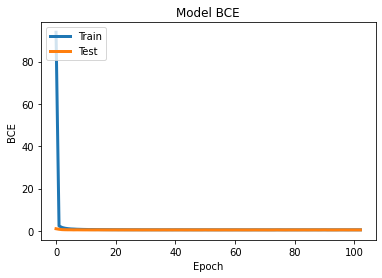

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['bce'])
plt.plot(history.history['val_bce'])
plt.title('Model BCE')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()